In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score

# Function to load images and labels from folders
def load_images_from_folders(folder1, folder2, folder4, folder11, label1, label2, label4, label11):
    
    images = []
    labels = []
    for folder, label in [(folder1, label1), (folder2, label2), (folder4, label4), (folder11, label11)]:
        if not os.path.isdir(folder):
            raise ValueError(f"Folder not found: {folder}")
        for filename in os.listdir(folder):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                img_path = os.path.join(folder, filename)
                img = cv2.imread(img_path)
                if img is not None:
                    images.append(img)
                    labels.append(label)
                else:
                    print(f"Warning: Could not read image: {img_path}")
    if not images:
        raise ValueError("No valid images found in the provided folders.")
    return images, labels

# Function to extract HOG features from images
def extract_features_hog(images, size=(128, 128)):
    
    features = []
    for img in images:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, size)
        hog_features = hog(resized, pixels_per_cell=(4, 4), cells_per_block=(1, 1), 
                           block_norm='L2-Hys', feature_vector=True)
        features.append(hog_features)
    return np.array(features)

# Function to find the best value of k using cross-validation
def find_best_k(X_train, y_train, k_range=20):
    
    param_grid = {'n_neighbors': np.arange(1, min(k_range, len(X_train)) + 1)}
    knn = KNeighborsClassifier()
    grid_search = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')  # 5-fold cross-validation
    grid_search.fit(X_train, y_train)
    best_k = grid_search.best_params_['n_neighbors']
    best_score = grid_search.best_score_ 
    return best_k, best_score

# Load training images from folders
folder1 = r"C:\Users\neham\OneDrive\Desktop\ml proj\set1"    # midhun
folder2 = r"C:\Users\neham\OneDrive\Desktop\ml proj\set2"    # adithyan
folder4 = r"C:\Users\neham\OneDrive\Desktop\ml proj\set4"    # shreya
folder11 = r"C:\Users\neham\OneDrive\Desktop\ml proj\set11"  # ashish

train_images, train_labels = load_images_from_folders(folder1, folder2, folder4, folder11, 
                                                      'midhun', 'adithyan', 'shreya', 'ashish')

# Extract features using HOG
X_train = extract_features_hog(train_images)

# Encode labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(train_labels)

# Normalize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

# Find the best k value using cross-validation
best_k, best_score = find_best_k(X_train, y_train, k_range=20)
print(f"Best k value: {best_k}")
print(f"Best cross-validation accuracy: {best_score:.2f}")

# Function to predict the label of a test image
def predict_image(image_path, threshold=0.6):
    img = cv2.imread(image_path)
    if img is None:
        raise ValueError(f"Could not read image at {image_path}")
    
    # Preprocess the test image: Convert to grayscale, resize, extract HOG features
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    resized = cv2.resize(gray, (128, 128))
    hog_features = hog(resized, pixels_per_cell=(4, 4), cells_per_block=(1, 1), 
                       block_norm='L2-Hys', feature_vector=True)
    
    # Scale the HOG features (same scaler as used for training data)
    hog_features = scaler.transform([hog_features])  # Ensure the test features are scaled properly
    
    # Predict probabilities
    probabilities = knn.predict_proba(hog_features)[0]
    max_confidence = np.max(probabilities)
    predicted_label = label_encoder.inverse_transform([np.argmax(probabilities)])[0]
    
    # Check if the confidence exceeds the threshold
    if max_confidence < threshold:
        return "Invalid Image", probabilities
    return predicted_label, probabilities

# Initialize and train the KNN classifier
knn = KNeighborsClassifier(n_neighbors=best_k)
knn.fit(X_train, y_train)


Best k value: 1
Best cross-validation accuracy: 0.95


KNeighborsClassifier(n_neighbors=1)

In [2]:
# Test the classifier with a new image
test_image_path = r"C:\Users\neham\OneDrive\Desktop\test_images\midhun.jpeg"

try:
    predicted_label, confidences = predict_image(test_image_path, threshold=0.6)
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence Scores: {confidences}")
    
except ValueError as e:
    print(e)


Predicted Label: midhun
Confidence Scores: [0. 0. 1. 0.]


In [3]:
# Test the classifier with a new image
test_image_path = r"C:\Users\neham\OneDrive\Desktop\test_images\ashish.jpeg"

try:
    predicted_label, confidences = predict_image(test_image_path, threshold=0.6)
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence Scores: {confidences}")
    
except ValueError as e:
    print(e)


Predicted Label: ashish
Confidence Scores: [0. 1. 0. 0.]


In [4]:
# Test the classifier with a new image
test_image_path = r"C:\Users\neham\OneDrive\Desktop\test_images\shreya.jpeg"

try:
    predicted_label, confidences = predict_image(test_image_path, threshold=0.6)
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence Scores: {confidences}")
    
except ValueError as e:
    print(e)


Predicted Label: shreya
Confidence Scores: [0. 0. 0. 1.]


In [5]:
# Test the classifier with a new image
test_image_path = r"C:\Users\neham\OneDrive\Desktop\test_images\adithyan.jpeg"

try:
    predicted_label, confidences = predict_image(test_image_path, threshold=0.6)
    print(f"Predicted Label: {predicted_label}")
    print(f"Confidence Scores: {confidences}")
    
except ValueError as e:
    print(e)


Predicted Label: adithyan
Confidence Scores: [1. 0. 0. 0.]


In [6]:
import tkinter as tk
import customtkinter
from PIL import Image, ImageTk
from tkinter import filedialog
from tkinter.scrolledtext import Text
from tkinter import ttk

def open_file_dialog():
    
    global image_path
    image_path = filedialog.askopenfilename(title="Select an Image", filetypes=[("Image Files", "*.jpg;*.jpeg;*.png;*.bmp;*.tiff")] )
    image_pil = Image.open(image_path)
    image_width, image_height = image_pil.size
     
    new_width = image_width // 3 
    new_height = image_height // 3 
    
    image = image_pil.resize((new_width, new_height))
    root.image_tk = ImageTk.PhotoImage(image)
    canvas = tk.Canvas(root, width=new_width, height=new_height)
    canvas.create_image(0, 0, anchor="nw", image=root.image_tk)
    canvas.place(relx=0.5, rely=0.4, anchor=tk.CENTER)
    style = ttk.Style()
    style.configure("TProgressbar", determinate_speed=10)
    
    progressbar = ttk.Progressbar(root, style="TProgressbar", length=300, mode='determinate')
    progressbar.place(relx=0.5, rely=0.73, anchor=tk.CENTER)
    progressbar.start()
    root.after(6200, progressbar.stop)
    root.after(2000, create_text_box)
    
    
def create_text_box():

    text_box = Text(root,height=7,width=28,wrap=tk.WORD,font=("Helvetica", 14),highlightthickness=2,highlightbackground="grey")
    text_box.place(relx=0.5, rely=0.88, anchor=tk.CENTER)
    predicted_label, confidences = predict_image(image_path, threshold=0.6)
    
    # output displayed in the text box
    text_box.insert(tk.END, f"Predicted Label: {predicted_label}\n")
    
    if predicted_label=="adithyan":
        text_box.insert(tk.END, "AM.SC.I5PHY21003")
    elif predicted_label=="ashish":
        text_box.insert(tk.END, "AM.SC.I5PHY21011")
    elif predicted_label=="midhun":
        text_box.insert(tk.END, "AM.SC.I5PHY21026")
    elif predicted_label=="shreya":
        text_box.insert(tk.END, "AM.SC.I5PHY21035")

    text_box.tag_configure("center", justify='center')
    text_box.tag_add("center", "1.0", "end")
    text_box.configure(bg="black", fg="white")

# Create the main Tkinter window as the master window
root = tk.Tk()
root.title("Face Recogniser")
root.geometry("750x750")
root.configure(bg='black')

# Create a Canvas widget in the master window to display the image
canvas = tk.Canvas(root, width=50, height=50, bg='black', highlightbackground='black')  # Initial canvas size
canvas.pack()

# Create a button to open the file dialog and display the image
button = customtkinter.CTkButton(master=root, text='Open Image', corner_radius=10, command=open_file_dialog)
button.place(relx=0.5, rely=0.05, anchor=tk.CENTER)

root.mainloop()

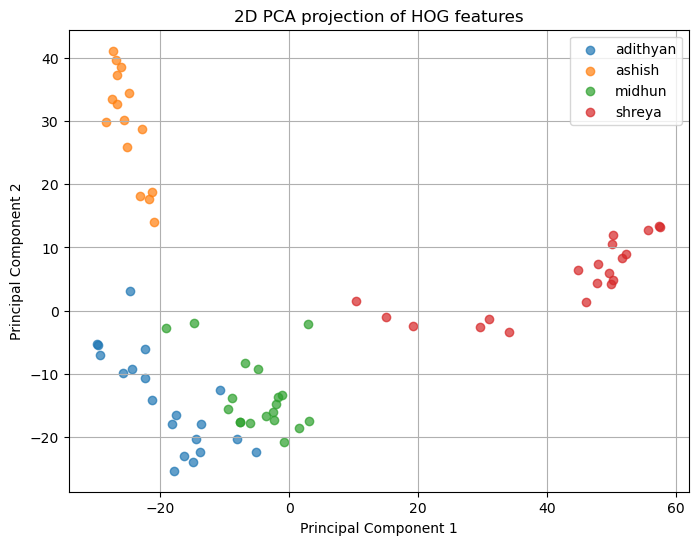

In [7]:
from sklearn.decomposition import PCA

# Apply PCA to reduce dimensionality to 2D for visualization
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)

# Create a scatter plot
plt.figure(figsize=(8, 6))

for i, label in enumerate(label_encoder.classes_):
    # Plot points of the current label (class)
    class_mask = (y_train == i)
    plt.scatter(X_train_2D[class_mask, 0], X_train_2D[class_mask, 1], label=label, alpha=0.7)

# Customize the plot
plt.title("2D PCA projection of HOG features")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.legend(loc="best")
plt.grid(True)
plt.show()

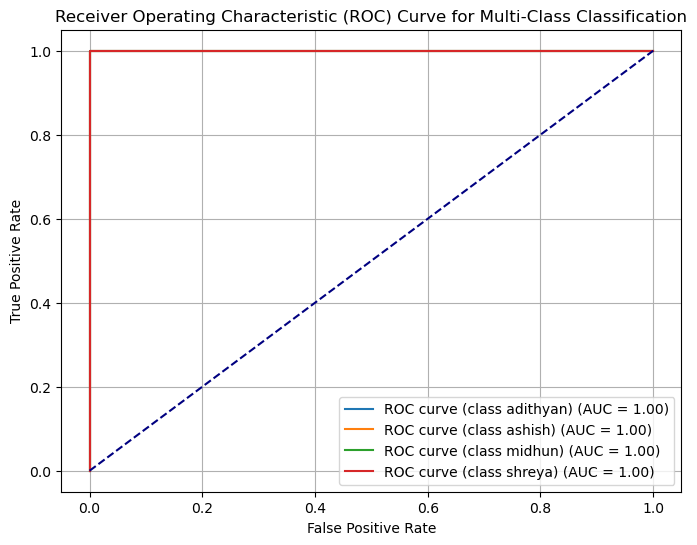

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Predict probabilities for ROC curve
y_prob = knn.predict_proba(X_train)

# Plot ROC curve for each class
fpr = {}
tpr = {}
roc_auc = {}

# Calculate ROC curve and AUC for each class
for i in range(len(label_encoder.classes_)):
    fpr[i], tpr[i], _ = roc_curve(y_train == i, y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curve
plt.figure(figsize=(8, 6))
for i in range(len(label_encoder.classes_)):
    plt.plot(fpr[i], tpr[i], label=f'ROC curve (class {label_encoder.classes_[i]}) (AUC = {roc_auc[i]:.2f})')

# Plot the random guess line (diagonal)
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')

# Customize the plot
plt.title('Receiver Operating Characteristic (ROC) Curve for Multi-Class Classification')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='best')
plt.grid(True)
plt.show()


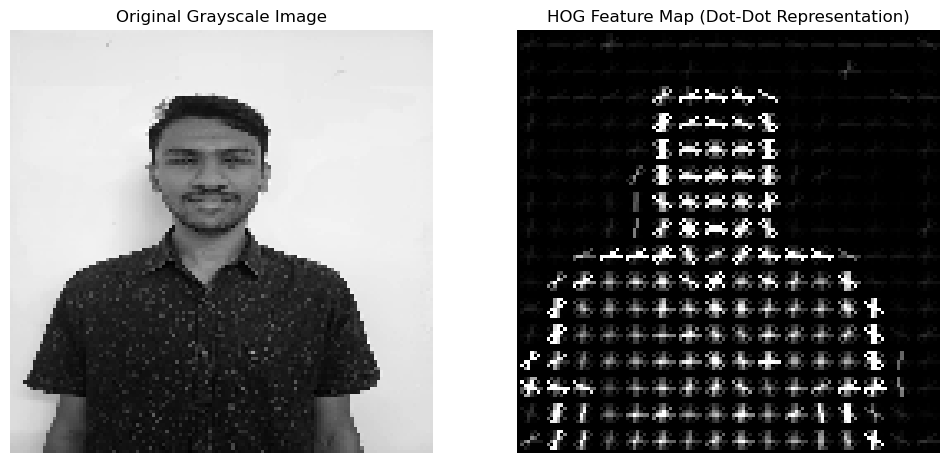

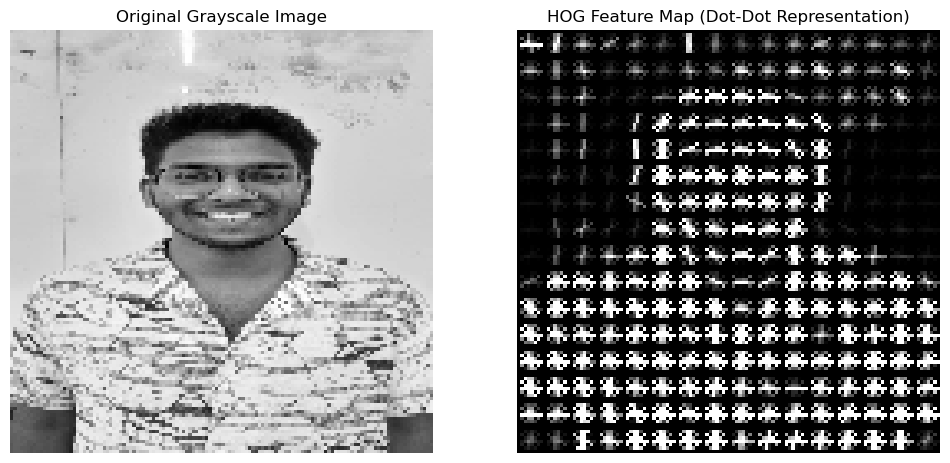

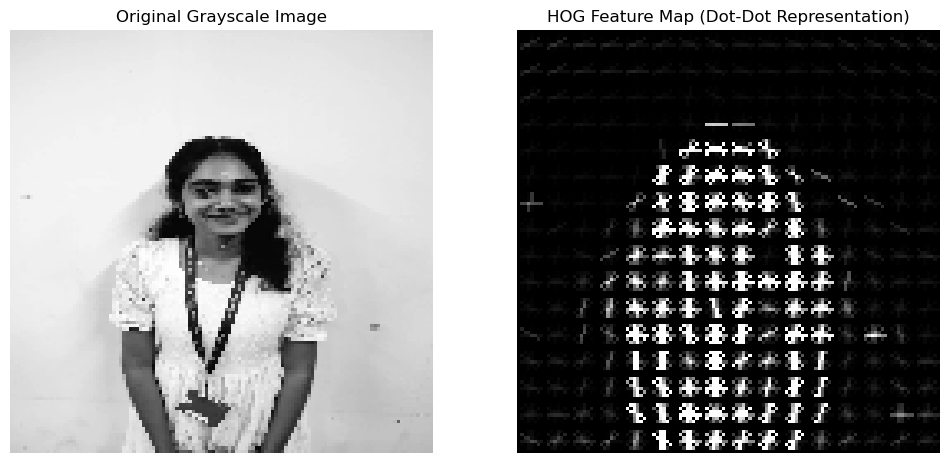

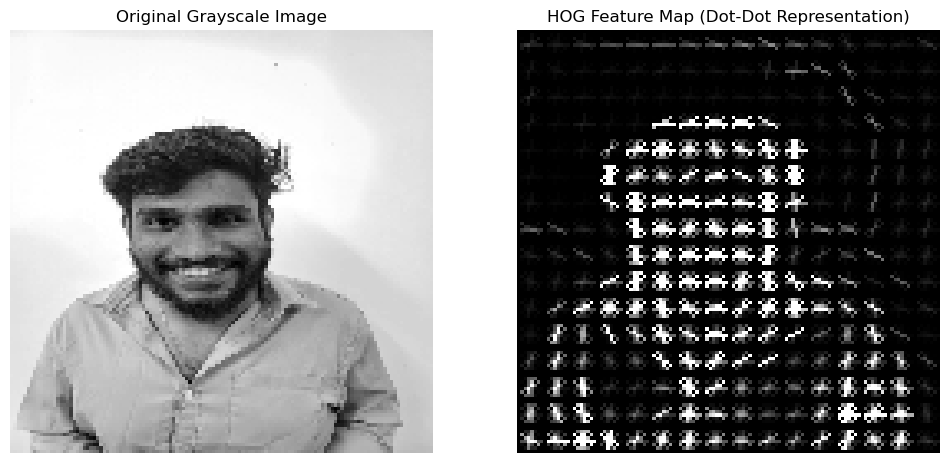

In [9]:
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure

# Function to extract HOG features from an image and return both the feature vector and the visualized image
def extract_hog_and_visualize(image_path):
    
    img = cv2.imread(image_path)
    
    if img is not None:
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        resized = cv2.resize(gray, (128, 128))

        # Extract HOG features from the resized image
        fd, hog_image = hog(resized, pixels_per_cell=(8, 8), cells_per_block=(2, 2),
                            visualize=True, block_norm='L2-Hys')

        # Rescale the image to make the HOG features more visible
        hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

        # Plot the original and HOG feature map side by side
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

        # Show original grayscale image
        ax1.imshow(resized, cmap=plt.cm.gray)
        ax1.set_title('Original Grayscale Image')
        ax1.axis('off')  # Hide the axes

        # Show HOG feature map
        ax2.imshow(hog_image_rescaled, cmap=plt.cm.gray)
        ax2.set_title('HOG Feature Map (Dot-Dot Representation)')
        ax2.axis('off')

        plt.show()
        
    else:
        print(f"Error: Could not load image from {image_path}")

# Visualize the HOG features of the test image
extract_hog_and_visualize(r"C:\Users\neham\OneDrive\Desktop\test_images\midhun.jpeg")
extract_hog_and_visualize(r"C:\Users\neham\OneDrive\Desktop\test_images\adithyan.jpeg")
extract_hog_and_visualize(r"C:\Users\neham\OneDrive\Desktop\test_images\shreya.jpeg")
extract_hog_and_visualize(r"C:\Users\neham\OneDrive\Desktop\test_images\ashish.jpeg")

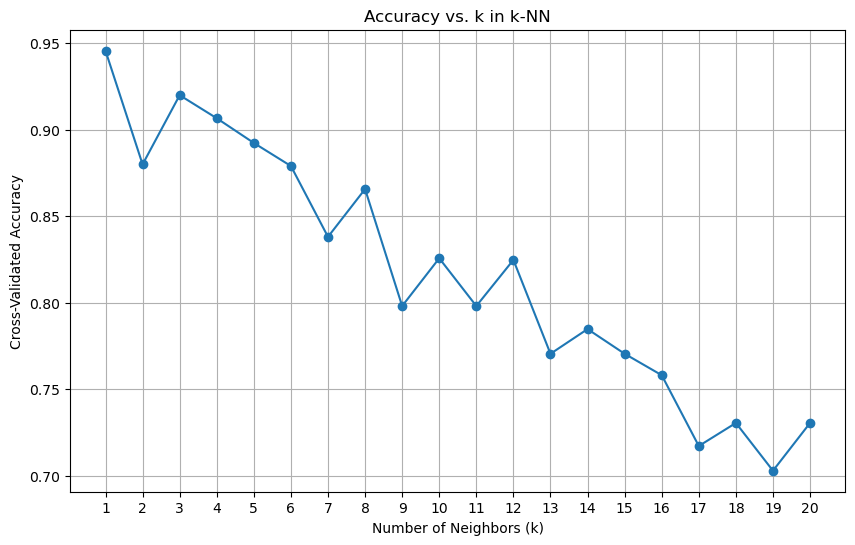

In [10]:
from sklearn.model_selection import cross_val_score


# Visualize accuracy vs k values
def plot_k_vs_accuracy(X_train, y_train, k_range=20):
    k_values = np.arange(1, min(k_range, len(X_train)) + 1)
    accuracies = []

    for k in k_values:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X_train, y_train, cv=5, scoring='accuracy')
        accuracies.append(scores.mean())  # Append the mean accuracy

    # Plot the results
    plt.figure(figsize=(10, 6))
    plt.plot(k_values, accuracies, marker='o', linestyle='-')
    plt.xlabel('Number of Neighbors (k)')
    plt.ylabel('Cross-Validated Accuracy')
    plt.title('Accuracy vs. k in k-NN')
    plt.xticks(k_values)
    plt.grid(True)
    plt.show()

# Call the function to plot the accuracy curve
plot_k_vs_accuracy(X_train, y_train, k_range=20)


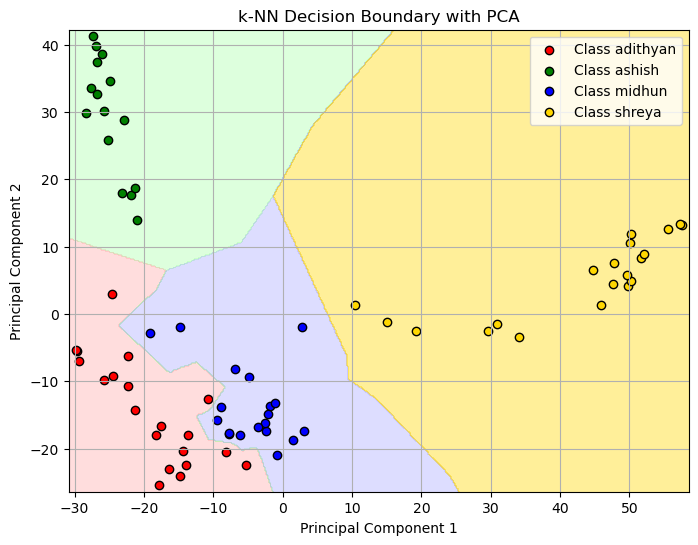

In [11]:
from matplotlib.colors import ListedColormap

# Decision boundary visualization for k-NN
def plot_decision_boundary(knn, X, y, title):
    
    pca = PCA(n_components=2)
    X_2D = pca.fit_transform(X)

    h = 0.2  # Step size in the mesh
    x_min, x_max = X_2D[:, 0].min() - 1, X_2D[:, 0].max() + 1
    y_min, y_max = X_2D[:, 1].min() - 1, X_2D[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Fit k-NN on 2D PCA data
    knn.fit(X_2D, y)
    Z = knn.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    # Create a color map
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF', '#FFD700'])
    cmap_bold = ['red', 'green', 'blue', 'gold']

    # Plot decision boundary
    plt.figure(figsize=(8, 6))
    plt.contourf(xx, yy, Z, alpha=0.4, cmap=cmap_light)

    # Overlay scatter plot of PCA-transformed data
    for i, label in enumerate(np.unique(y)):
        plt.scatter(X_2D[y == label, 0], X_2D[y == label, 1],
                    color=cmap_bold[i], edgecolor='k', label=f'Class {label_encoder.inverse_transform([label])[0]}')

    plt.title(title)
    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend()
    plt.grid(True)
    plt.show()

# Plot decision boundary
plot_decision_boundary(knn, X_train, y_train, "k-NN Decision Boundary with PCA")


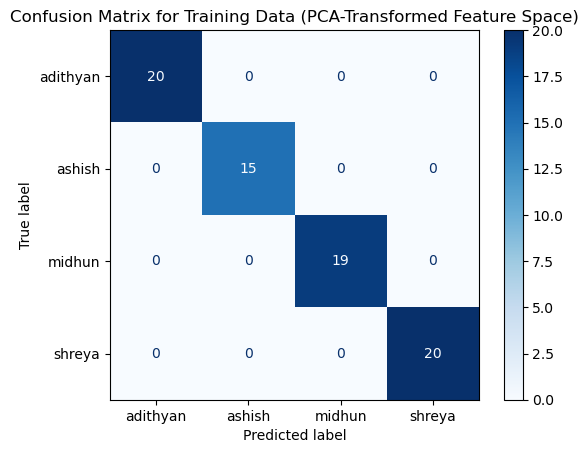

In [12]:
from sklearn.decomposition import PCA
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


# Apply PCA to reduce dimensionality to 2D
pca = PCA(n_components=2)
X_train_2D = pca.fit_transform(X_train)

# Train KNN on PCA-transformed data
knn_2D = KNeighborsClassifier(n_neighbors=best_k)
knn_2D.fit(X_train_2D, y_train)

# Generate predictions for training set using PCA-transformed data
y_pred_train_2D = knn_2D.predict(X_train_2D)

# Plot confusion matrix for PCA-transformed data
cm = confusion_matrix(y_train, y_pred_train_2D)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap='Blues', values_format='d')
plt.title('Confusion Matrix for Training Data (PCA-Transformed Feature Space)')
plt.show()


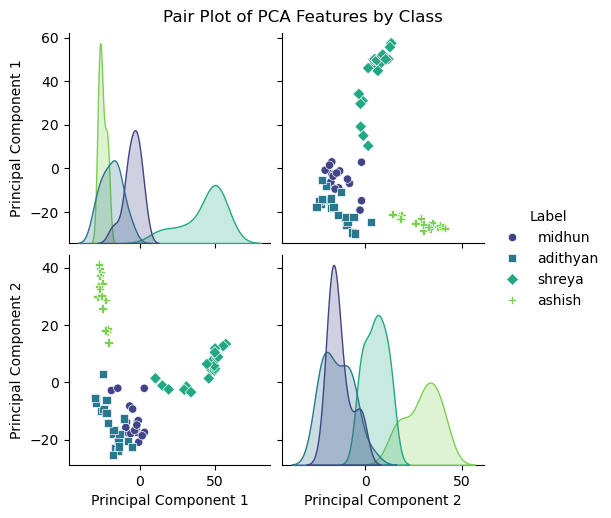

In [13]:
import seaborn as sns
import pandas as pd

# Create a DataFrame for visualization
pca_df = pd.DataFrame(X_train_2D, columns=["Principal Component 1", "Principal Component 2"])
pca_df['Label'] = label_encoder.inverse_transform(y_train)

# Pair plot to show separation in PCA space
sns.pairplot(pca_df, hue='Label', palette='viridis', markers=["o", "s", "D", "P"])
plt.suptitle('Pair Plot of PCA Features by Class', y=1.02)
plt.show()
